# day 21 of #66daysofdata_NLP
## `Plagiarism-Detection`


* ref: 
    - [towardsdatascience.com](https://towardsdatascience.com/simple-plagiarism-detection-in-python-2314ac3aee88)
    
    
* ## Dataset:
    - [A Corpus of Plagiarised Short Answers](https://ir.shef.ac.uk/cloughie/resources/plagiarism_corpus.html) 
    - Context:
        - file is associated with one Task (task A-E) and one Category of plagiarism, 
        - There are 5 questions which are labeled as tasks A-E. For example, Task A asks the question: "What is inheritance in object oriented programming?"
        - Category labels:                    
                * 0 = non
                * 1 = heavy
                * 2 = light
                * 3 = cut
                * -1 = orig, this is a special value that indicates an original file.
                
        - Class column labels:
                *  0: Any answer text that is not plagiarized (non) should have the class label 0.
                *  1: Any plagiarized answer texts should have the class label 1.
                * -1: And any orig texts will have a special label -1.
                
        - Datatype:
                * train:  Training data, for model training.
                * test:   Testing data, for model evaluation.
                * orig:   Special, source text category: orig.
                
        ### Categories of plagiarism

        Each text file has an associated plagiarism label/category:

        1. `Plagiarized categories`: `cut`, `light`, and `heavy`.
                - cut answers:   copy directly from a source text, 
                - light answers: are based on the source text but include some light rephrasing, 
                - heavy answers: are based on the source text, but heavily rephrased (and will likely be the most challenging kind of plagiarism to detect).

        2. `Non-plagiarized category`: non.

            non indicates that an answer is not plagiarized; `the Wikipedia source text is not used` to create this answer.

        3. Special, source text category: `orig`.

            This is a specific category for the original, `Wikipedia source text`. We will use these files only for comparison purposes.

***


<div style="text-align:center">    
    <img  src="../images/plagiarism.png" width='400px'//> 
</div>


### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.util import ngrams, pad_sequence, everygrams
from nltk.tokenize import word_tokenize
from nltk.lm import MLE, WittenBellInterpolated
import numpy as np
#import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
import seaborn as sns
import matplotlib.pyplot as plt


file_directory = '../datasets/plagiarism_data/'

###  Load data set

In [2]:
#load all the datasets 
df = pd.read_csv(file_directory+'plagiarism.csv')

display(df)

,File,Task,Category,Class,Text,Datatype
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...,train
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train
...,...,...,...,...,...,...
95,orig_taska.txt,a,-1,-1,in object oriented programming inheritance is ...,orig
96,orig_taskb.txt,b,-1,-1,pagerank is a link analysis algorithm used by ...,orig
97,orig_taskc.txt,c,-1,-1,vector space model or term vector model is an ...,orig
98,orig_taskd.txt,d,-1,-1,in probability theory bayes theorem often call...,orig


In [3]:
def give_sample_text(index, cat_2_plag=''):
    sample_text = df['Text'][index]
    text_task    = df['Task'][index]
    text_cat    = df['Category'][index]
    orig_text = (df['Text'][(df['Task'] ==text_task) & (df['Datatype'] =='orig')].values)[0]
    return sample_text, text_cat, orig_text 

cat_2_plag = {'0':'No','1':'heavy','2':'light','3':'cut'}


In [4]:
index = 21
sample_text, text_cat, orig_text  = give_sample_text(index, cat_2_plag)
print(f"Sample '{cat_2_plag[str(text_cat)]} plagiarism' student text:\n\n{sample_text[:300]}...\n\nIts original text is: \n\n{orig_text[:300]}...")

Sample 'heavy plagiarism' student text:

pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents such as the world wide web with the purpose of measuring its relative importance within the set the algorithm may be applied to any col...

Its original text is: 

pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents such as the world wide web with the purpose of measuring its relative importance within the set the algorithm may be applied to any col...


# N-gram Language Model

`N-gram` in NLP: The continuous sequence of 'N' elements from a text or speech sample.
<div style="text-align:center">    
    <img  src="../images/../images/N-gram.png" width='500px'/>
    <a href="https://devopedia.org/images/article/219/7356.1569499094.png">img ref</a> 
</div>

An `N-gram language model` predicts the likelihood of a particular N-gram appearing in any sequence of words in a language. 
<div style="text-align:center">    
    <img  src="../images/../images/Ngram_example.png"  />
    <a href="https://www.esat.kuleuven.be/psi/spraak/demo/Recog/page3.html#Ngram">img ref</a> 
</div>

* An N-gram Language Model `assigns a score to words depending on the context of the preceding window`.
***
<h2 align="center">  Plagiarism:        N-gram_LM   vs   Transformers </h2>   
 

The N-gram model isn't particularly sophisticated and can't handle long-range dependencies or abstract semantic information.
`RNN` or `Transformers`, do a better job of capturing `long-range relationships` and greater degrees of abstraction.
> Plagiarism, on the other hand, focuses on `duplicated word sequences` rather than abstract similarities.
***

In [5]:
# set ngram number
n = 4

# pad the text and tokenize
training_data = list(pad_sequence(word_tokenize(orig_text), n, 
                                  pad_left=True, 
                                  left_pad_symbol="<s>"))
print(f"Tokenized original Wiki text:\n\n{training_data[:200]}...")

Tokenized original Wiki text:

['<s>', '<s>', '<s>', 'pagerank', 'is', 'a', 'link', 'analysis', 'algorithm', 'used', 'by', 'the', 'google', 'internet', 'search', 'engine', 'that', 'assigns', 'a', 'numerical', 'weighting', 'to', 'each', 'element', 'of', 'a', 'hyperlinked', 'set', 'of', 'documents', 'such', 'as', 'the', 'world', 'wide', 'web', 'with', 'the', 'purpose', 'of', 'measuring', 'its', 'relative', 'importance', 'within', 'the', 'set', 'the', 'algorithm', 'may', 'be', 'applied', 'to', 'any', 'collection', 'of', 'entities', 'with', 'reciprocal', 'quotations', 'and', 'references', 'the', 'numerical', 'weight', 'that', 'it', 'assigns', 'to', 'any', 'given', 'element', 'e', 'is', 'also', 'called', 'the', 'pagerank', 'of', 'e', 'and', 'denoted', 'by', 'pr', 'e', 'the', 'name', 'pagerank', 'is', 'a', 'trademark', 'of', 'google', 'and', 'the', 'pagerank', 'process', 'has', 'been', 'patented', 'u', 's', 'patent', '6', '285', '999', 'however', 'the', 'patent', 'is', 'assigned', 'to', 'sta

In [6]:
# generate ngrams
ngrams = list(everygrams(training_data, max_len=n))
print("Number of ngrams:", len(ngrams))

Number of ngrams: 2146


In [7]:
ngrams[:12]

[('<s>',),
 ('<s>', '<s>'),
 ('<s>', '<s>', '<s>'),
 ('<s>', '<s>', '<s>', 'pagerank'),
 ('<s>',),
 ('<s>', '<s>'),
 ('<s>', '<s>', 'pagerank'),
 ('<s>', '<s>', 'pagerank', 'is'),
 ('<s>',),
 ('<s>', 'pagerank'),
 ('<s>', 'pagerank', 'is'),
 ('<s>', 'pagerank', 'is', 'a')]

* These N-grams can be used to fit a model.
    * A basic MLE (Maximum Likelihood Estimator) 
    * more complex models like WittenBellInterpolated that employ interpolation to cope with unseen N-grams 
    
    are all available in NLTK. 

In [8]:
# build ngram language models
model = WittenBellInterpolated(n)
model.fit([ngrams], vocabulary_text=training_data)
print(model.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 232 items>


In [9]:
# Tokenize and pad the text
testing_data = list(pad_sequence(word_tokenize(sample_text), n, 
                                 pad_left=True,
                                 left_pad_symbol="<s>"))
print(f"The '{cat_2_plag[str(text_cat)]} plagiarism' tokenized student text:\n\n{testing_data[:300]}...")

The 'heavy plagiarism' tokenized student text:

['<s>', '<s>', '<s>', 'pagerank', 'is', 'a', 'link', 'analysis', 'algorithm', 'used', 'by', 'the', 'google', 'internet', 'search', 'engine', 'that', 'assigns', 'a', 'numerical', 'weighting', 'to', 'each', 'element', 'of', 'a', 'hyperlinked', 'set', 'of', 'documents', 'such', 'as', 'the', 'world', 'wide', 'web', 'with', 'the', 'purpose', 'of', 'measuring', 'its', 'relative', 'importance', 'within', 'the', 'set', 'the', 'algorithm', 'may', 'be', 'applied', 'to', 'any', 'collection', 'of', 'entities', 'with', 'reciprocal', 'quotations', 'and', 'references', 'pagerank', 'uses', 'in', 'google', 'toolbar', 'measures', 'popularity', 'of', 'a', 'site', 'marketing', 'value', 'updated', 'periodically', 'in', 'google', 'directory', 'pagerank', 'sort', 'links', 'within', 'categories', 'volunteers', 'evaluate', 'classify', 'annotate', 'open', 'directory', 'project', 'using', 'pagerank']...


In [10]:
print("Length of test data:", len(testing_data))

Length of test data: 93


In [11]:
# assign scores
scores = []
for i, item in enumerate(testing_data[n-1:]):
    s = model.score(item, testing_data[i:i+n-1])
    scores.append(s)

scores_np = np.array(scores)

In [12]:
print("Length of test data:", len(scores_np))

Length of test data: 90


In [13]:
plagiarism_score = np.average(scores_np)

print(f"The plagiarism score for this sample '{cat_2_plag[str(text_cat)]} plagiarism' student text is:\n\n{100*plagiarism_score:.2f} %")

The plagiarism score for this sample 'heavy plagiarism' student text is:

51.69 %


## Visualize and compare the `Original` vs `Plagiarism`

In [14]:
def text_2_labels(testing_data, scores_np,width = 8)  : 
    # set width and height
    
    height = np.ceil(len(testing_data)/width).astype("int32")
    #print("Width, Height:", width, ",", height)

    # copy scores to rectangular blank array
    a = np.zeros(width*height)
    a[:len(scores_np)] = scores_np
    diff = len(a) - len(scores_np)

    # apply gaussian smoothing for aesthetics
    a = gaussian_filter(a, sigma=1.0)

    # reshape to fit rectangle
    a = a.reshape(-1, width)

    # format labels
    labels = [" ".join(testing_data[i:i+width]) for i in range(n-1, len(testing_data), width)]
    labels_individual = [x.split() for x in labels]
    labels_individual[-1] += [""]*diff
    labels = [f"{x:60.60}" for x in labels]
    return labels_individual, labels, a

def plot_plagiarism_heatmap(heat, labels, title):
    fig, ax = plt.subplots(figsize=(30,7),tight_layout=True)
    cmap=sns.color_palette("flare", as_cmap=True)
    r = sns.heatmap(heat,cmap=cmap)
    ax.set_yticklabels(labels, rotation=0, fontsize="12", va="center",ha='left', position=(-0.9,0.28))
    ax.set_title(title, fontsize=20)
    plt.show()

In [15]:
# generate labels
labels_individual, labels, heat = text_2_labels(testing_data, scores_np,width = 8)
labels

['pagerank is a link analysis algorithm used by               ',
 'the google internet search engine that assigns a            ',
 'numerical weighting to each element of a hyperlinked        ',
 'set of documents such as the world wide                     ',
 'web with the purpose of measuring its relative              ',
 'importance within the set the algorithm may be              ',
 'applied to any collection of entities with reciprocal       ',
 'quotations and references pagerank uses in google toolbar   ',
 'measures popularity of a site marketing value updated       ',
 'periodically in google directory pagerank sort links within ',
 'categories volunteers evaluate classify annotate open direct',
 'using pagerank                                              ']

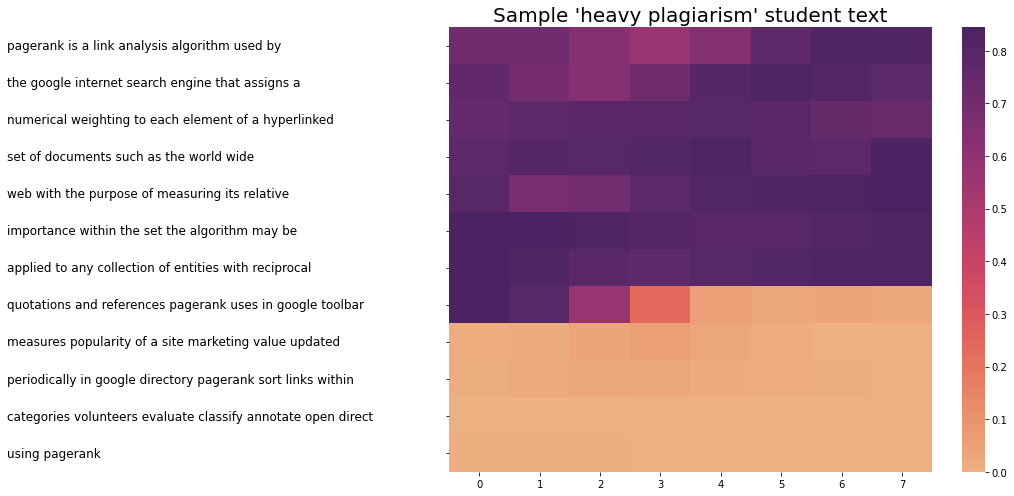

In [16]:
# plot the plagiarism heatmap
title = f"Sample '{cat_2_plag[str(text_cat)]} plagiarism' student text"
plot_plagiarism_heatmap(heat, labels, title)

> The `plagiarized example`, in which the `material is copied from Wikipedia with occasional word replacements`.
The updated words are represented by the lighter coloured pixels.
This approach enables determining whether sections of a document were plagiarised much easy.
Author's photo. 

In [17]:
# all process in One function
def ngram_plagiarism_pcore(orig_text, sample_text, cat_2_plag, text_cat='', n_ngram = 4, return_score=False):
    

    # pad the text and tokenize
    training_data = list(pad_sequence(word_tokenize(orig_text), n_ngram, 
                                      pad_left=True, 
                                      left_pad_symbol="<s>"))
    
    # generate ngrams
    ngrams = list(everygrams(training_data, max_len=n_ngram))
    
    # build ngram language models
    model = WittenBellInterpolated(n_ngram)
    model.fit([ngrams], vocabulary_text=training_data)
    
    # Tokenize and pad the text
    testing_data = list(pad_sequence(word_tokenize(sample_text), n_ngram, 
                                     pad_left=True,
                                     left_pad_symbol="<s>"))
    
    # assign scores
    scores = []
    for i, item in enumerate(testing_data[n_ngram-1:]):
        s = model.score(item, testing_data[i:i+n_ngram-1])
        scores.append(s)
        
    scores_np = np.array(scores)
    plagiarism_score = np.average(scores_np)
    if return_score: 
        return plagiarism_score 
    else: 
        pass
    # generate labels
    labels_individual, labels, heat = text_2_labels(testing_data, scores_np,width = 8)
    
    # plot the plagiarism heatmap
    title = f"Sample '{cat_2_plag[str(text_cat)]} plagiarism' student text\nPlagiarism score: {100*plagiarism_score:.2f} %"
    plot_plagiarism_heatmap(heat, labels, title)
    


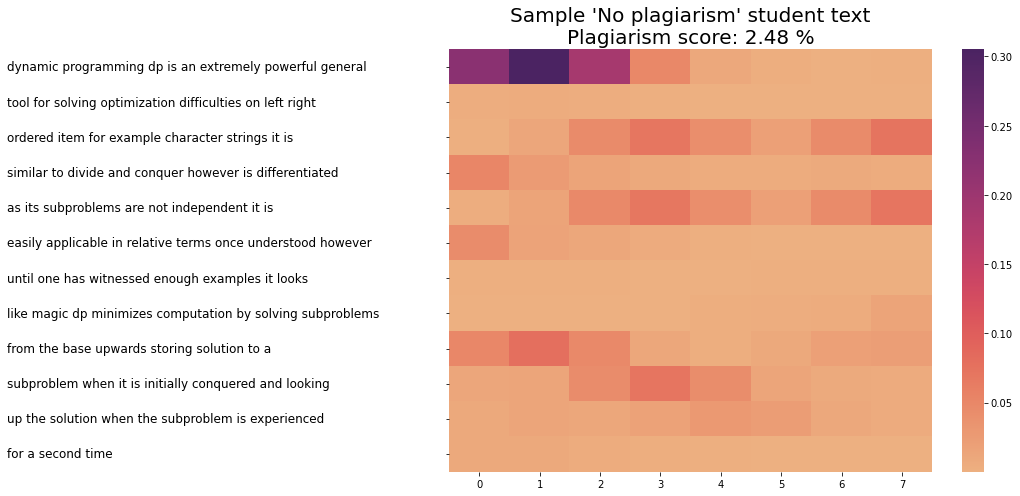

In [18]:
index = 19
sample_text, text_cat, orig_text  = give_sample_text(index, cat_2_plag)    
ngram_plagiarism_pcore(orig_text, sample_text, cat_2_plag, text_cat, n_ngram = 4)

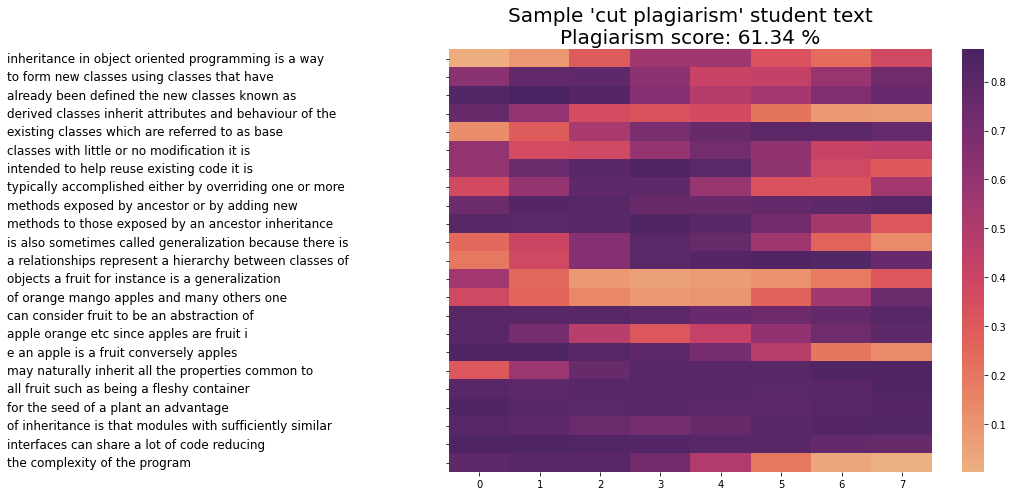

In [19]:
index = 15
sample_text, text_cat, orig_text  = give_sample_text(index, cat_2_plag)    
ngram_plagiarism_pcore(orig_text, sample_text, cat_2_plag, text_cat, n_ngram = 4)

***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 22 of #66daysofdata_NLP </i>
    </h1>      
</div>

<h3 align="center">Feature Engineering --> Similarity Features</h3>   

<p style='text-align: center;'>
    <mark>Similarity features</mark> are used to determine how similar a particular <mark>response text</mark> is to the original <mark>Wikipedia source content</mark> 
</p>
  


 
***
## Containment features:

Containment is defined as the `intersection of` the `Wikipedia Source Text's n-gram word count` (S) and the `Student Answer Text's n-gram word count` (A) divided by the Student `Answer Text's n-gram word count`. 

<div align="center"> 
    <img  src="../images/containment.png" />
</div>   


In [20]:
# Calculate the ngram containment for one answer file/source file pair in a df
from sklearn.feature_extraction.text import CountVectorizer
def calculate_containment(df, n, answer_filename, verbose=0):
    '''Calculates the containment between a given answer text and its associated source text.
       This function creates a count of ngrams (of a size, n) for each text file in our data.
       Then calculates the containment by finding the ngram count for a given answer text, 
       and its associated source text, and calculating the normalized intersection of those counts.
       :param df: A dataframe with columns,
           'File', 'Task', 'Category', 'Class', 'Text', and 'Datatype'
       :param n: An integer that defines the ngram size
       :param answer_filename: A filename for an answer text in the df, ex. 'g0pB_taskd.txt'
       :return: A single containment value that represents the similarity
           between an answer text and its source text.
    '''
    
    # your code here
    lol = list(df['File'])
    inde = lol.index(answer_filename)
    answer_text = str(df['Text'][inde])
    if df['Task'][inde] == 'a':
        source_text = str(df['Text'][95])
    elif df['Task'][inde] == 'b':
        source_text = str(df['Text'][96])
    elif df['Task'][inde] == 'c':
        source_text = str(df['Text'][97])
    elif df['Task'][inde] == 'd':
        source_text = str(df['Text'][98])
    else:
        source_text = str(df['Text'][99])
    
    if verbose == 1:
        print(f"The student answer is:\n\n{answer_text[:300]}\n\n\nThe source_text is:\n\n{source_text[:300]}\n")
    #Initializing our CountVectorizer
    counts = CountVectorizer(analyzer = 'word', ngram_range = (n, n))

    #Fit the text with our CountVectorizer and assign it to vocab2int
    vocab2int = counts.fit([answer_text, source_text]).vocabulary_
    if verbose == 1:
        print('______________________________________')
        print(f"Sample {n}-gram vocab with their ind\n\n  { {k: vocab2int[k] for k in list(vocab2int)[:3]} }")
    #Generating the ngram_array
    ngrams = counts.fit_transform([answer_text, source_text])    
    ngram_array = ngrams.toarray()    
    

    #Creating the intersection list
    intersection_list = np.amin(ngram_array, axis=0)
    
    if verbose == 1:
        print('______________________________________')
        print(f"ngram_array for ANswer is:\n{ngram_array[0]}\n\n ngram_array for Source is:\n{ngram_array[1]}\n\nThe intersection array (S^A) is:\n{ intersection_list }\n\n")

    #Sum up number of the intersection counts
    intersection = np.sum(intersection_list)

    #Counting up the number of n-grams in the answer text
    answer_idx = 0
    answer_cnt = np.sum(ngram_array[answer_idx])

    # normalize and get final containment value
    containment_val =  intersection / answer_cnt

    return containment_val

### __Containment score for sample answer__

In [21]:
i = 10 # sample row
filename = df.loc[i, 'File']
text_cat    = df['Category'][i]
print(f"**** Sample '{cat_2_plag[str(text_cat)]} plagiarism' student text ****\n")
c = calculate_containment(df, n, filename,1)
print(f"The containment score between 'Answer' & 'Source' is:    {c:.3f}")

**** Sample 'heavy plagiarism' student text ****

The student answer is:

inheritance in object oriented programming is where a new class is formed using classes which have allready been defined these classes have have some of the behavior and attributes which where existent in the classes that it inherited from the peropos of inheritance in object oriented programming is


The source_text is:

in object oriented programming inheritance is a way to form new classes instances of which are called objects using classes that have already been defined the inheritance concept was invented in 1967 for simula  the new classes known as derived classes take over or inherit attributes and behavior of

______________________________________
Sample 4-gram vocab with their ind

  {'inheritance in object oriented': 207, 'in object oriented programming': 195, 'object oriented programming is': 284}
______________________________________
ngram_array for ANswer is:
[0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 

### Sontainment score for first few files

In [22]:
# select a value for n
n = 3

# indices for first few files
test_indices = range(5)

# iterate through files and calculate containment
category_vals = []
containment_vals = []
for i in test_indices:
    # get level of plagiarism for a given file index
    
    category_vals.append(cat_2_plag[str(df.loc[i, 'Category'])]+' plagiarism')
    # calculate containment for given file and n
    filename = df.loc[i, 'File']
    c = calculate_containment(df, n, filename)
    containment_vals.append(np.round(c,3))

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print(str(n)+'-gram containment values: \n', containment_vals)

Original category values: 
 ['No plagiarism', 'cut plagiarism', 'light plagiarism', 'heavy plagiarism', 'No plagiarism']

3-gram containment values: 
 [0.009, 0.964, 0.614, 0.157, 0.032]


***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 23 of #66daysofdata_NLP </i>
    </h1>      
</div>

# 

<h3 align="center">Longest Common Subsequence</h3>   

<p style='text-align: center;'>
    <mark>The longest common subsequence</mark>  is the longest string of words (or letters) shared by the Wikipedia Source Text (S) and the Student Answer Text (S) (A).
By dividing by the total number of words (or letters) in the Student Answer Text, this result is also normalised.  
</p>
  


 
***
## Calculate the longest common subsequence:

<div align="center"> 
    <img  src="../images/common_subseq_words.png" />
    <a href="https://github.com/sachinrai416/Project_Plagiarism_Detection./blob/master/Project_Plagiarism_Detection/notebook_ims/common_subseq_words.png?raw=true">img ref</a>
</div>  

* Even if there are some words in between, we regard this as the longest common sub sequence between the two texts since those words come in left-to-right order in each document, sequentially.

* I obtain a value of 20 if I add up all of the words I discovered in common. `LCS is 20 characters long`.

* `Divide this value by the whole length of the student answer` to `normalize` it; in this case, that length is just 27.As a result, the lcs norm word function should return  <mark>20/27, or 0.7408</mark>. 

***
### LCS, dynamic progeamming


<div align="center"> 
    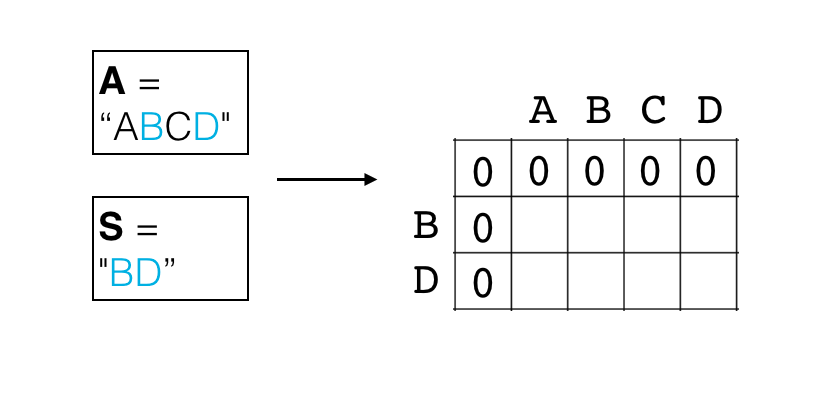
        
    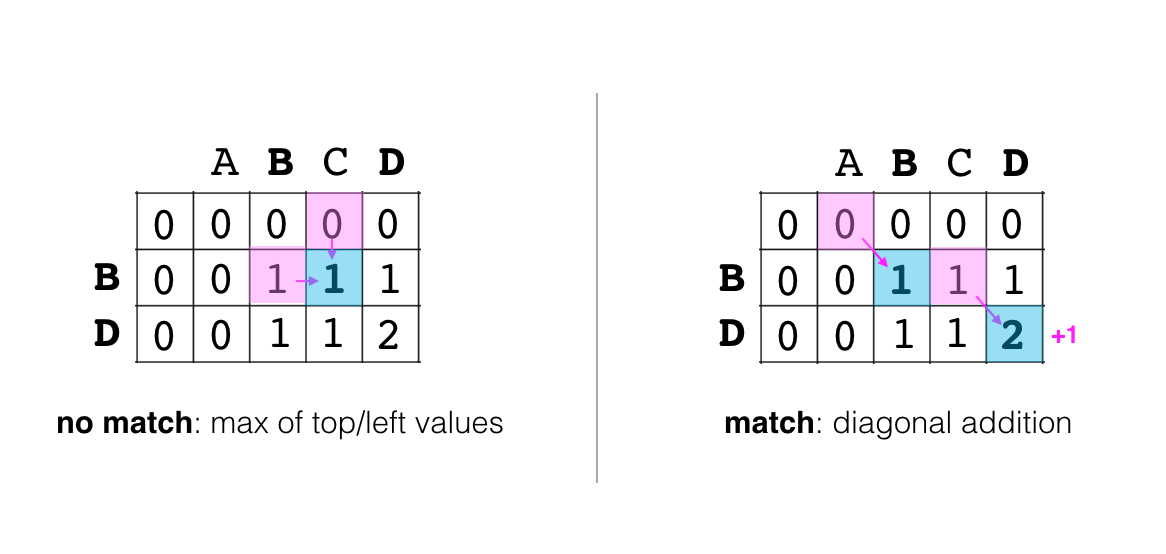
    <a href="https://github.com/sachinrai416/Project_Plagiarism_Detection./tree/master/Project_Plagiarism_Detection">img ref</a>
</div>


In [23]:
# Compute the normalized LCS given an answer text and a source text
import sys
def lcs_norm_word(answer_text, source_text):
    '''Computes the longest common subsequence of words in two texts; returns a normalized value.
       :param answer_text: The pre-processed text for an answer text
       :param source_text: The pre-processed text for an answer's associated source text
       :return: A normalized LCS value'''
    
    # your code here
    answer_split = answer_text.split()
    source_split = source_text.split()
    m = len(answer_split)
    n = len(source_split)
    L = [[None]*(n + 1) for i in range(m + 1)] 
  
    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif answer_split[i-1] == source_split[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n]/m

### Test cells

In [24]:
# Run the test scenario from above
# does your function return the expected value?

A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"

# calculate LCS
lcs = lcs_norm_word(A, S)
print('LCS = ', lcs)

LCS =  0.7407407407407407


In [25]:
# test on your own
test_indices = range(5) # look at first few files

category_vals = []
lcs_norm_vals = []
# iterate through first few docs and calculate LCS
for i in test_indices:
    category_vals.append(cat_2_plag[str(df.loc[i, 'Category'])]+' plagiarism')
    # get texts to compare
    answer_text = df.loc[i, 'Text'] 
    task = df.loc[i, 'Task']
    # we know that source texts have Class = -1
    orig_rows = df[(df['Class'] == -1)]
    orig_row = orig_rows[(orig_rows['Task'] == task)]
    source_text = orig_row['Text'].values[0]
    
    # calculate lcs
    lcs_val = lcs_norm_word(answer_text, source_text)
    lcs_norm_vals.append(np.round(lcs_val,3))

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print('Normalized LCS values: \n', lcs_norm_vals)

Original category values: 
 ['No plagiarism', 'cut plagiarism', 'light plagiarism', 'heavy plagiarism', 'No plagiarism']

Normalized LCS values: 
 [0.192, 0.821, 0.846, 0.316, 0.243]


***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 24 of #66daysofdata_NLP </i>
    </h1>      
</div>


<h2 align="laft">Create All Features</h2>   

#### 1. Creating ngram score

In [26]:
def create_ngram_score_features(df, n, column_name=None):
    
    ngram_scores = []
    
    if(column_name==None):
        column_name = 'Ngram_score'
    
    # iterates through dataframe rows
    for i in df.index:
        file = df.loc[i, 'File']
        # Computes features using calculate_containment function
        if df.loc[i,'Category'] > -1:
            sample_text, text_cat, orig_text  = give_sample_text(i)    
            score = ngram_plagiarism_pcore(orig_text, sample_text, cat_2_plag, text_cat, n_ngram = n, return_score=True)
            ngram_scores.append(score)
        # Sets value to -1 for original tasks 
        else:
            ngram_scores.append(-1)
    
    print(str(n)+'-gram score features created!')
    return ngram_scores


#### 2. Creating multiple containment features

In [27]:
# Function returns a list of containment features, calculated for a given n 
# Should return a list of length 100 for all files in a df
def create_containment_features(df, n, column_name=None):
    
    containment_values = []
    
    if(column_name==None):
        column_name = 'c_'+str(n) # c_1, c_2, .. c_n
    
    # iterates through dataframe rows
    for i in df.index:
        file = df.loc[i, 'File']
        # Computes features using calculate_containment function
        if df.loc[i,'Category'] > -1:
            c = calculate_containment(df, n, file)
            containment_values.append(c)
        # Sets value to -1 for original tasks 
        else:
            containment_values.append(-1)
    
    print(str(n)+'-gram containment features created!')
    return containment_values

#### 2. Creating LCS features

In [28]:
# Function creates lcs feature and add it to the dataframe
def create_lcs_features(df, column_name='lcs_word'):
    
    lcs_values = []
    
    # iterate through files in dataframe
    for i in df.index:
        # Computes LCS_norm words feature using function above for answer tasks
        if df.loc[i,'Category'] > -1:
            # get texts to compare
            answer_text = df.loc[i, 'Text'] 
            task = df.loc[i, 'Task']
            # we know that source texts have Class = -1
            orig_rows = df[(df['Class'] == -1)]
            orig_row = orig_rows[(orig_rows['Task'] == task)]
            source_text = orig_row['Text'].values[0]

            # calculate lcs
            lcs = lcs_norm_word(answer_text, source_text)
            lcs_values.append(lcs)
        # Sets to -1 for original tasks 
        else:
            lcs_values.append(-1)

    print('LCS features created!')
    return lcs_values

# Create a features DataFrame by selecting an ngram_range

In [29]:
# Define an ngram range
ngram_range = range(1,7)


# The following code may take a minute to run, depending on your ngram_range
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
features_list = []

# Create features in a features_df
all_features = np.zeros((len(ngram_range)+2, len(df)))

# Calculate features for containment for ngrams in range
i=0
for n in ngram_range:
    column_name = 'containment_'+str(n)
    features_list.append(column_name)
    # create containment features
    all_features[i]=np.squeeze(create_containment_features(df, n))
    i+=1

# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(create_lcs_features(df))
i+=1

# Calculate features for LCS_Norm Words 
features_list.append('ngram_score')
all_features[i]= np.squeeze(create_ngram_score_features(df, 4))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()

1-gram containment features created!
2-gram containment features created!
3-gram containment features created!
4-gram containment features created!
5-gram containment features created!
6-gram containment features created!
LCS features created!
4-gram score features created!

Features:  ['containment_1', 'containment_2', 'containment_3', 'containment_4', 'containment_5', 'containment_6', 'lcs_word', 'ngram_score']



In [30]:
features_df.head()

,containment_1,containment_2,containment_3,containment_4,containment_5,containment_6,lcs_word,ngram_score
0,0.398148,0.079070,0.009346,0.000000,0.000000,0.000000,0.191781,0.031855
1,1.000000,0.984694,0.964103,0.943299,0.922280,0.901042,0.820755,0.751871
2,0.869369,0.719457,0.613636,0.515982,0.449541,0.382488,0.846491,0.503249
3,0.593583,0.268817,0.156757,0.108696,0.081967,0.060440,0.316062,0.155118
4,0.544503,0.115789,0.031746,0.005319,0.000000,0.000000,0.242574,0.061369


## Correlated Features

To decide which characteristics are `too closely connected with each other` to incorporate both features in a single model, consider `feature correlation` over the whole dataset.
Due to the limited sample size, you can utilize the complete dataset for this analysis. 

In [31]:
# Create correlation matrix for just Features to determine different models to test
corr_matrix = features_df.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,containment_1,containment_2,containment_3,containment_4,containment_5,containment_6,lcs_word,ngram_score
containment_1,1.00,0.94,0.90,0.89,0.88,0.87,0.97,0.94
containment_2,0.94,1.00,0.99,0.98,0.97,0.96,0.98,0.99
containment_3,0.90,0.99,1.00,1.00,0.99,0.98,0.97,0.99
containment_4,0.89,0.98,1.00,1.00,1.00,0.99,0.95,0.99
containment_5,0.88,0.97,0.99,1.00,1.00,1.00,0.95,0.98
containment_6,0.87,0.96,0.98,0.99,1.00,1.00,0.94,0.97
lcs_word,0.97,0.98,0.97,0.95,0.95,0.94,1.00,0.98
ngram_score,0.94,0.99,0.99,0.99,0.98,0.97,0.98,1.00


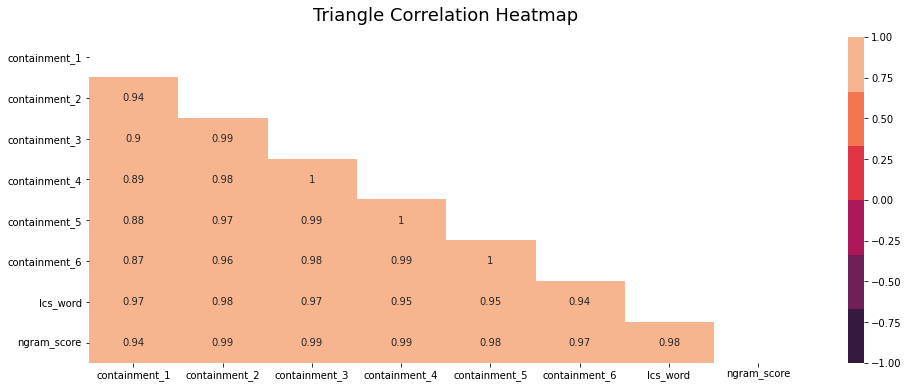

In [32]:
import seaborn as sns

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("rocket"))
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

* We choose some characteristics to include in your final model `based on the value of correlation in the features`. 

In [38]:
def train_test_data(df, features_df, selected_features, binary_classification=True):
 
    tr_tes_df = df[df['Category']!=-1]

    
    X = features_df[features_df['containment_1']>-1][selected_features]
    
    
    train_ind = tr_tes_df['Datatype']=='train'
    test_ind  = tr_tes_df['Datatype']=='test'
    
    if binary_classification:
        y = tr_tes_df[['Class']]
    else:
        # multi class
        y = tr_tes_df[['Category']]    
    
    
    train_x, train_y = X[train_ind], y[train_ind]                 
    test_x, test_y   = X[test_ind] , y[test_ind]
    
    
    return (train_x, train_y), (test_x, test_y)

## Binary classification train-test split

In [42]:
# selected features
selected_features = ['containment_1', 'containment_5', 'lcs_word', 'ngram_score']

(train_x, train_y), (test_x, test_y) = train_test_data(df, features_df, selected_features, binary_classification=True)
# check that division of samples seems correct
# these should add up to 95 (100 - 5 original files)
print('Training size: ', len(train_x))
print('Test size: ', len(test_x))
print()
print('Training df sample: \n', pd.concat([train_x[:10],train_y[:10]],axis=1))

Training size:  70
Test size:  25

Training df sample: 
     containment_1  containment_5  lcs_word  ngram_score  Class
0        0.398148       0.000000  0.191781     0.031855      0
2        0.869369       0.449541  0.846491     0.503249      1
3        0.593583       0.081967  0.316062     0.155118      1
4        0.544503       0.000000  0.242574     0.061369      0
5        0.329502       0.000000  0.161172     0.030048      0
6        0.590308       0.000000  0.301653     0.077514      0
8        0.759777       0.245714  0.484305     0.354699      1
11       0.516129       0.000000  0.270833     0.023417      0
12       0.440860       0.000000  0.223958     0.050041      0
13       0.979452       0.788732  0.900000     0.720995      1
